In [75]:
import glob
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib import path, colors
from matplotlib.patches import Circle, Polygon
import skimage.io as io
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta
from scipy.ndimage import generic_filter
from scipy.interpolate import RegularGridInterpolator
import numba as nb
from os.path import exists

In [2]:
from caribbean_map import *

In [3]:
%load_ext autoreload
%autoreload 2

import beachings

In [4]:
ds_origin = pd.read_csv(f'releases/particles_info_uniform.csv')

In [ ]:
criteria = 'c1'

if not exists(f'beachings_{criteria}_uniform.csv'):
    f = open(f'beachings_{criteria}_uniform.csv', 'w')
    f.write("release, land, cid0, lon0, lat0, days, cid1, lon1, lat1\n")
    f.close()

    for year in range(2010, 2022):
        for month in range(1,13):
            file = f'../data/output/cm_uniform/cm_uniform_{year}-{month:02d}-01.nc'

            ds = xr.open_dataset(file)
            lon = ds.lon.values
            lat = ds.lat.values
            nb_traj, nb_obs = lon.shape
            origin_date = datetime(2010,1,1)

            # distance
            d = beachings.haversine(lon, lat)

            # identify beaching
            b_idx = np.zeros(nb_traj, dtype=int)

            # a drifters is considered beach if it travels less 100km in the past 30 days
            threshold_distance = 100*1000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c1(d[i], threshold_distance, period)
          
            beached = b_idx != -99999

            land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
            lon0 = ds_origin.loc[beached]['longitude'].values
            lat0 = ds_origin.loc[beached]['latitude'].values
            lon1 = lon[beached, b_idx[beached]]
            lat1 = lat[beached, b_idx[beached]]

            b_release = np.full(np.sum(beached), f'{year}-{month}-01') # constant release
            b_time = b_idx[beached]  # days 

            cid_0 = ds_origin.loc[beached]['country id'].values
            cid_1 = beachings.global_country_id(lon1, lat1)

            # append to csv
            fid = open(f'beachings_{criteria}_uniform.csv', 'a')
            np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, b_time, cid_1, lon1, lat1)), 
                       fmt='%s, %d, %d, %.10f, %.10f, %d, %d, %.10f, %.10f',
                       delimiter=', ', newline ='\n')
            fid.close()

In [ ]:
criteria = 'c2'

if not exists(f'beachings_{criteria}_uniform.csv'):
    f = open(f'beachings_{criteria}_uniform.csv', 'w')
    f.write("release, land, cid0, lon0, lat0, days, cid1, lon1, lat1\n")
    f.close()

    for year in range(2010, 2022):
        for month in range(1, 13):
            file = f'../data/output/cm_uniform/cm_uniform_{year}-{month:02d}-01.nc'

            ds = xr.open_dataset(file)
            lon = ds.lon.values
            lat = ds.lat.values
            nb_traj, nb_obs = lon.shape
            origin_date = datetime(2010,1,1)

            # distance
            d = beachings.haversine(lon, lat)

            # identify beaching
            b_idx = np.zeros(nb_traj, dtype=int)

            # a drifters is considered beach if it travels less than 3km for 30 days in a row
            threshold_distance = 3000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c2(d[i], threshold_distance, period)

            beached = b_idx != -99999

            land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
            lon0 = ds_origin.loc[beached]['longitude'].values
            lat0 = ds_origin.loc[beached]['latitude'].values
            lon1 = lon[beached, b_idx[beached]]
            lat1 = lat[beached, b_idx[beached]]

            b_release = np.full(np.sum(beached), f'{year}-{month}-01') # constant release
            b_time = b_idx[beached]  # days 

            cid_0 = ds_origin.loc[beached]['country id'].values
            cid_1 = beachings.global_country_id(lon1, lat1)

            # append to csv
            fid = open(f'beachings_{criteria}_uniform.csv', 'a')
            np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, b_time, cid_1, lon1, lat1)), 
                       fmt='%s,%d,%d,%.10f,%.10f,%d,%d,%.10f,%.10f',
                       delimiter=',', newline ='\n')
            fid.close()

In [76]:
# distance [km] from the coastlines (negative in the ocean)
dist_coast = xr.open_dataset('../data/raw/dist_to_GSHHG_v2.3.7_1m.nc')

fdist = RegularGridInterpolator((dist_coast.lon.data, dist_coast.lat.data), 
                                 dist_coast.dist.data.T, bounds_error=False)

In [77]:
# test
pts = np.array([[-84.322620%360, 30.5], # Tallahassee
                [-84.322620%360, 29]])  # GoM ~1deg from coast

fdist(pts)

array([ 41.44530375, -88.32496285])

In [80]:
criteria = 'c3'

# parameters
# distance is negative in the ocean values larger than ~-8 km are in the last HYCOM boxes or on land
threshold_distance = -8  # km 
probability = 1-0.5**(1/5)
delay = 30  # days

if not exists(f'beachings_{criteria}_uniform.csv'):
    f = open(f'beachings_{criteria}_uniform.csv', 'w')
    f.write("release, land, cid0, lon0, lat0, days, cid1, lon1, lat1\n")
    f.close()

    for year in range(2010, 2022):
        for month in range(1, 13):
            file = f'../data/output/cm_uniform/cm_uniform_{year}-{month:02d}-01.nc'

            ds = xr.open_dataset(file)
            lon = ds.lon.values
            lat = ds.lat.values
            nb_traj, nb_obs = lon.shape
            origin_date = datetime(2010,1,1)

            # distance
            d = fdist(np.column_stack((lon.flatten()%360, lat.flatten()))).reshape(lon.shape)

            # identify beaching
            b_idx = beachings.identify_beaching_c3(d, probability, threshold_distance, delay)
            
            beached = b_idx != -99999

            land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
            lon0 = ds_origin.loc[beached]['longitude'].values
            lat0 = ds_origin.loc[beached]['latitude'].values
            lon1 = lon[beached, b_idx[beached]]
            lat1 = lat[beached, b_idx[beached]]

            b_release = np.full(np.sum(beached), f'{year}-{month}-01') # constant release
            b_time = b_idx[beached]  # days 

            cid_0 = ds_origin.loc[beached]['country id'].values
            cid_1 = beachings.global_country_id(lon1, lat1)

            # append to csv
            fid = open(f'beachings_{criteria}_uniform.csv', 'a')
            np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, b_time, cid_1, lon1, lat1)), 
                       fmt='%s,%d,%d,%.10f,%.10f,%d,%d,%.10f,%.10f',
                       delimiter=',', newline ='\n')
            fid.close()

In [71]:
def season(date, nh = True):
    """
    North Hemisphere (nh): season = winter, spring, summer, fall [0,1,2,3]
    South Hemisphere: season = summer, fall, winter, spring [2,3,0,1]
    """
    month, day = date.month, date.day
    
    if (2, 21) <= (month, day) < (5, 20):    # nh spring
        return 1 if nh else 3
    elif (5, 20) <= (month, day) < (8, 21):  # nh summer
        return 2 if nh else 0
    elif (8, 21) <= (month, day) < (11, 21): # nh fall
        return 3 if nh else 1
    else:                                    # nh winter
        return 0 if nh else 2  

In [59]:
display(ds)

,release,land,cid0,lon0,lat0,days,cid1,lon1,lat1,beached,season
0,2010-01-01,1,14,-62.410036,16.852480,54,181,-65.762398,18.185991,2010-02-24,0
1,2010-01-01,1,14,-62.381441,16.909294,55,181,-65.839828,18.076298,2010-02-25,0
2,2010-01-01,1,14,-62.392107,16.888089,55,181,-66.184959,17.924837,2010-02-25,0
3,2010-01-01,1,14,-62.427517,16.896646,59,181,-66.972145,17.924917,2010-03-01,0
4,2010-01-01,1,14,-62.358354,16.854672,114,64,-69.407639,19.276052,2010-04-25,0
...,...,...,...,...,...,...,...,...,...,...,...
2266467,2021-12-01,0,208,-56.757700,6.161017,30,96,-57.356140,6.242014,2021-12-31,3
2266468,2021-12-01,0,208,-56.745996,6.186368,31,96,-57.543846,6.337937,2022-01-01,3
2266469,2021-12-01,0,208,-56.685673,6.194329,31,96,-57.595287,6.358966,2022-01-01,3
2266470,2021-12-01,0,208,-56.654369,6.125220,31,96,-57.424252,6.285975,2022-01-01,3


In [60]:
# plot
ds = pd.read_csv('beachings_c1_uniform.csv', delimiter=', ', parse_dates=['release'])
ds['beached'] = [ds.release[i] + timedelta(days=int(ds.days.values[i])) for i in range(0, len(ds))]
ds['season'] = [season(d) for d in ds.beached]

/tmp/ipykernel_585747/909488931.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ds = pd.read_csv('beachings_c1_uniform.csv', delimiter=', ', parse_dates=['release'])


In [16]:
ds_l = xr.open_dataset('../data/process/land_GLBv0.08.nc')
land = ds_l.land.values
plon = ds_l.plon.values # center of cell
plat = ds_l.plat.values
qlon = ds_l.qlon.values # corner of cell
qlat = ds_l.qlat.values 
ds_l.close()

# subsample
grid_f = 2
qlon = qlon[::grid_f]
qlat = qlat[::grid_f]
plon = np.convolve(qlon, [0.5, 0.5], mode='valid')
plat = np.convolve(qlat, [0.5, 0.5], mode='valid')

### summed into qlon,qlat boxes

In [17]:
ret_c = stats.binned_statistic_2d(ds['lon1'].values, ds['lat1'].values, values=np.ones_like(ds['lat1'].values),
                                  statistic='count', 
                                  bins=[qlon, qlat])
beached_mass = ret_c.statistic.T

### summed into closest coastal box

In [18]:
@nb.njit
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1 = np.radians(lon1), np.radians(lat1)
    lon2, lat2 = np.radians(lon2), np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    # distance
    earthRadius = 6371 # km
    d = 2 * np.arcsin(np.sqrt(a)) * earthRadius # km
    return d

In [19]:
# this is ugly and I'm sure there is a function for this
# but I could not find quickly and got annoyed
land_sub = np.zeros((len(plat), len(plon)), dtype='bool')
for i in range(0, len(plat)):
    for j in range(0, len(plon)):
        ri = slice(i*grid_f, (i+1)*grid_f)
        rj = slice(j*grid_f, (j+1)*grid_f)
        land_sub[i,j] = True if np.mean(land[ri,rj]) > 0 and np.mean(land[ri,rj]) < 1 else False

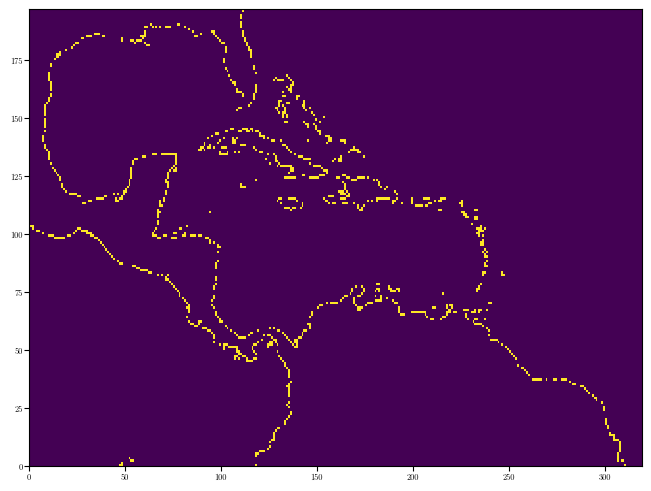

In [20]:
plt.pcolormesh(land_sub)

In [21]:
gplon, gplat = np.meshgrid(plon, plat)
gi, gj = np.where(land_sub)
land_lon, land_lat = gplon[land_sub], gplat[land_sub]

In [22]:
coastal_beached_mass = np.zeros_like(land_sub, dtype='float')

for i in range(0, len(ds['lon1'])):
    d = haversine(ds['lon1'][i], ds['lat1'][i], land_lon, land_lat)
    k = np.argmin(d) # closest land box
    coastal_beached_mass[gi[k],gj[k]] += 1 # (i,j) -> (gi[k], gj[k])

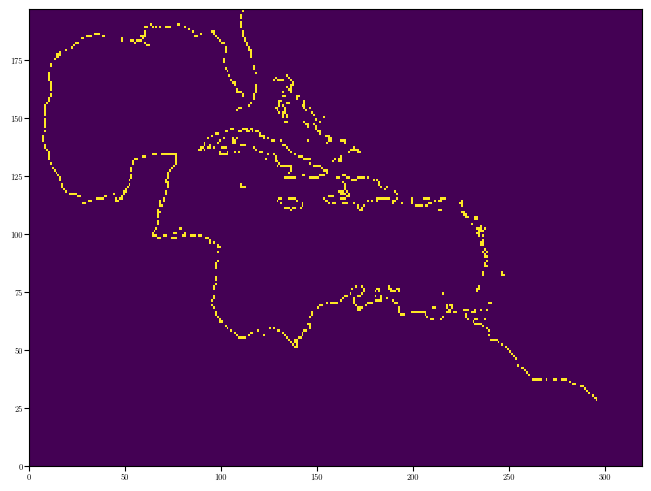

In [23]:
plt.pcolormesh(coastal_beached_mass>0)

In [24]:
np.max(beached_mass)

20964.0

In [25]:
# 5 particles per bins
# hotspot calculated at a 2x larger scale so 20 particles x 12 x 12
baseline_particles = 2880

In [26]:
def radius(mass):
    categories = np.array([1, 2, 5, 10])
    size = np.array([0.75, 1.0, 2.0, 4.0])/6
    arg = np.array([np.argmin(np.abs(m-categories)) for m in mass/baseline_particles])
    return arg+0.5, size[arg]

In [27]:
nnz = np.where(beached_mass)
colors, scaled_mass = radius(beached_mass[nnz])

In [28]:
np.sum(colors == 0.5)

3625

In [29]:
scaled_mass

array([0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125])

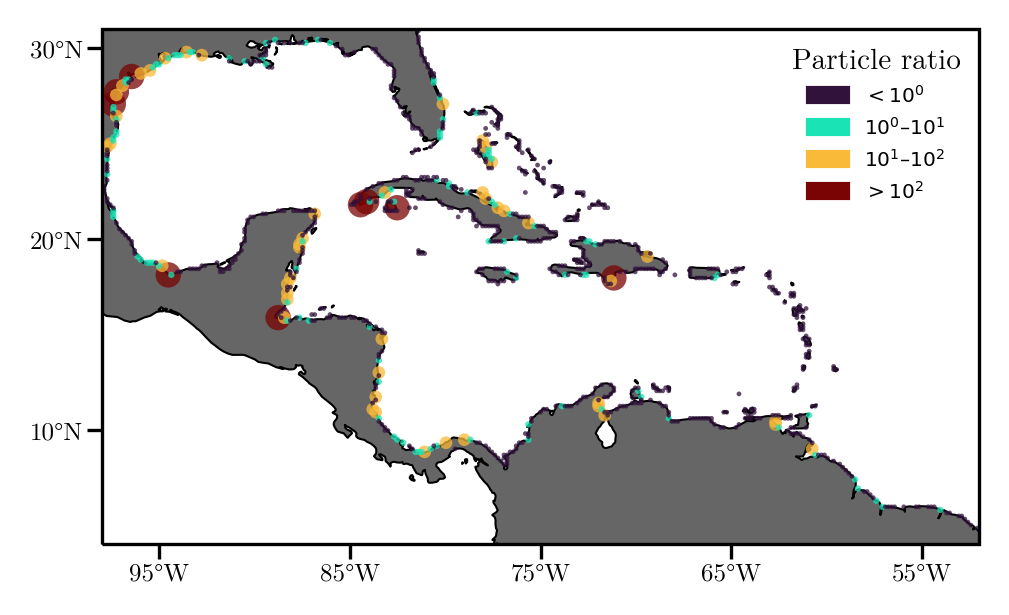

In [72]:
fig = plt.figure(dpi=300, figsize=fsh)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

geo_map(ax)
    
#a = ax.scatter(plon[nnz[1]], plat[nnz[0]], 
#           s=np.exp(beached_mass[nnz]/(0.20*np.nanmax(beached_mass))), 
#          c=beached_mass[nnz], lw=2, marker='o',
#          )

#nnz = np.where(beached_mass)
#colors, scaled_mass = radius(beached_mass[nnz])
nnz = np.where(coastal_beached_mass)
colors, scaled_mass = radius(coastal_beached_mass[nnz])

patches = []
for x1, y1, r in sorted(zip(plon[nnz[1]], plat[nnz[0]], scaled_mass), key = lambda x: x[2], reverse=True):
    circle = Circle((x1, y1), r)
    #circle = Wedge((x1, y1), r, 0, 360, width=0.1)
    patches.append(circle)

cmap_name = plt.cm.turbo
     
p = PatchCollection(patches, alpha=0.75, cmap=cmap_name)
p.set_array(sorted(colors, reverse=True))
p.set_clim([np.min(colors), np.max(colors)])
ax.add_collection(p)

handles = []
handles.append(Polygon([(0,0),(5,0)], color=cmap_name(p.norm(np.min(colors))), label=f'$<10^{0}$'))
for i,c in enumerate(np.unique(colors)[1:-1]):
    handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap_name(p.norm(c)), label=f'$10^{i}–10^{i+1}$'))
handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap_name(p.norm(np.max(colors))), label=f'$>10^{i+1}$'))
ax.legend(handles=handles, frameon=False, fontsize='x-small', title="Particle ratio")  

fig.savefig(f'figures/hotspot_uniform.png', format='png', dpi=600)

# seasonality

In [61]:
coastal_beached_mass_seasons = np.zeros((4, land_sub.shape[0], land_sub.shape[1]), dtype='float')

for i in range(0, len(ds['lon1'])):
    d = haversine(ds['lon1'][i], ds['lat1'][i], land_lon, land_lat)
    k = np.argmin(d) # closest land box
    coastal_beached_mass_seasons[ds['season'][i]][gi[k],gj[k]] += 1 # (i,j) -> (gi[k], gj[k])

In [62]:
np.sum(coastal_beached_mass)

2266472.0

In [63]:
# this has to match the previous value
np.sum(coastal_beached_mass_seasons)

2266472.0

In [64]:
coastal_beached_mass_seasons.shape

(4, 197, 319)

In [65]:
np.max(coastal_beached_mass_seasons, axis=(1,2))

array([11191., 11957., 12369.,  8631.])

In [66]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']

def radius_season(mass):
    categories = np.array([1, 2, 5, 10])
    size = np.array([0.75, 1.0, 2.0, 4.0])/6
    arg = np.array([np.argmin(np.abs(m-categories)) for m in mass/baseline_particles*4])
    return arg+0.5, size[arg]

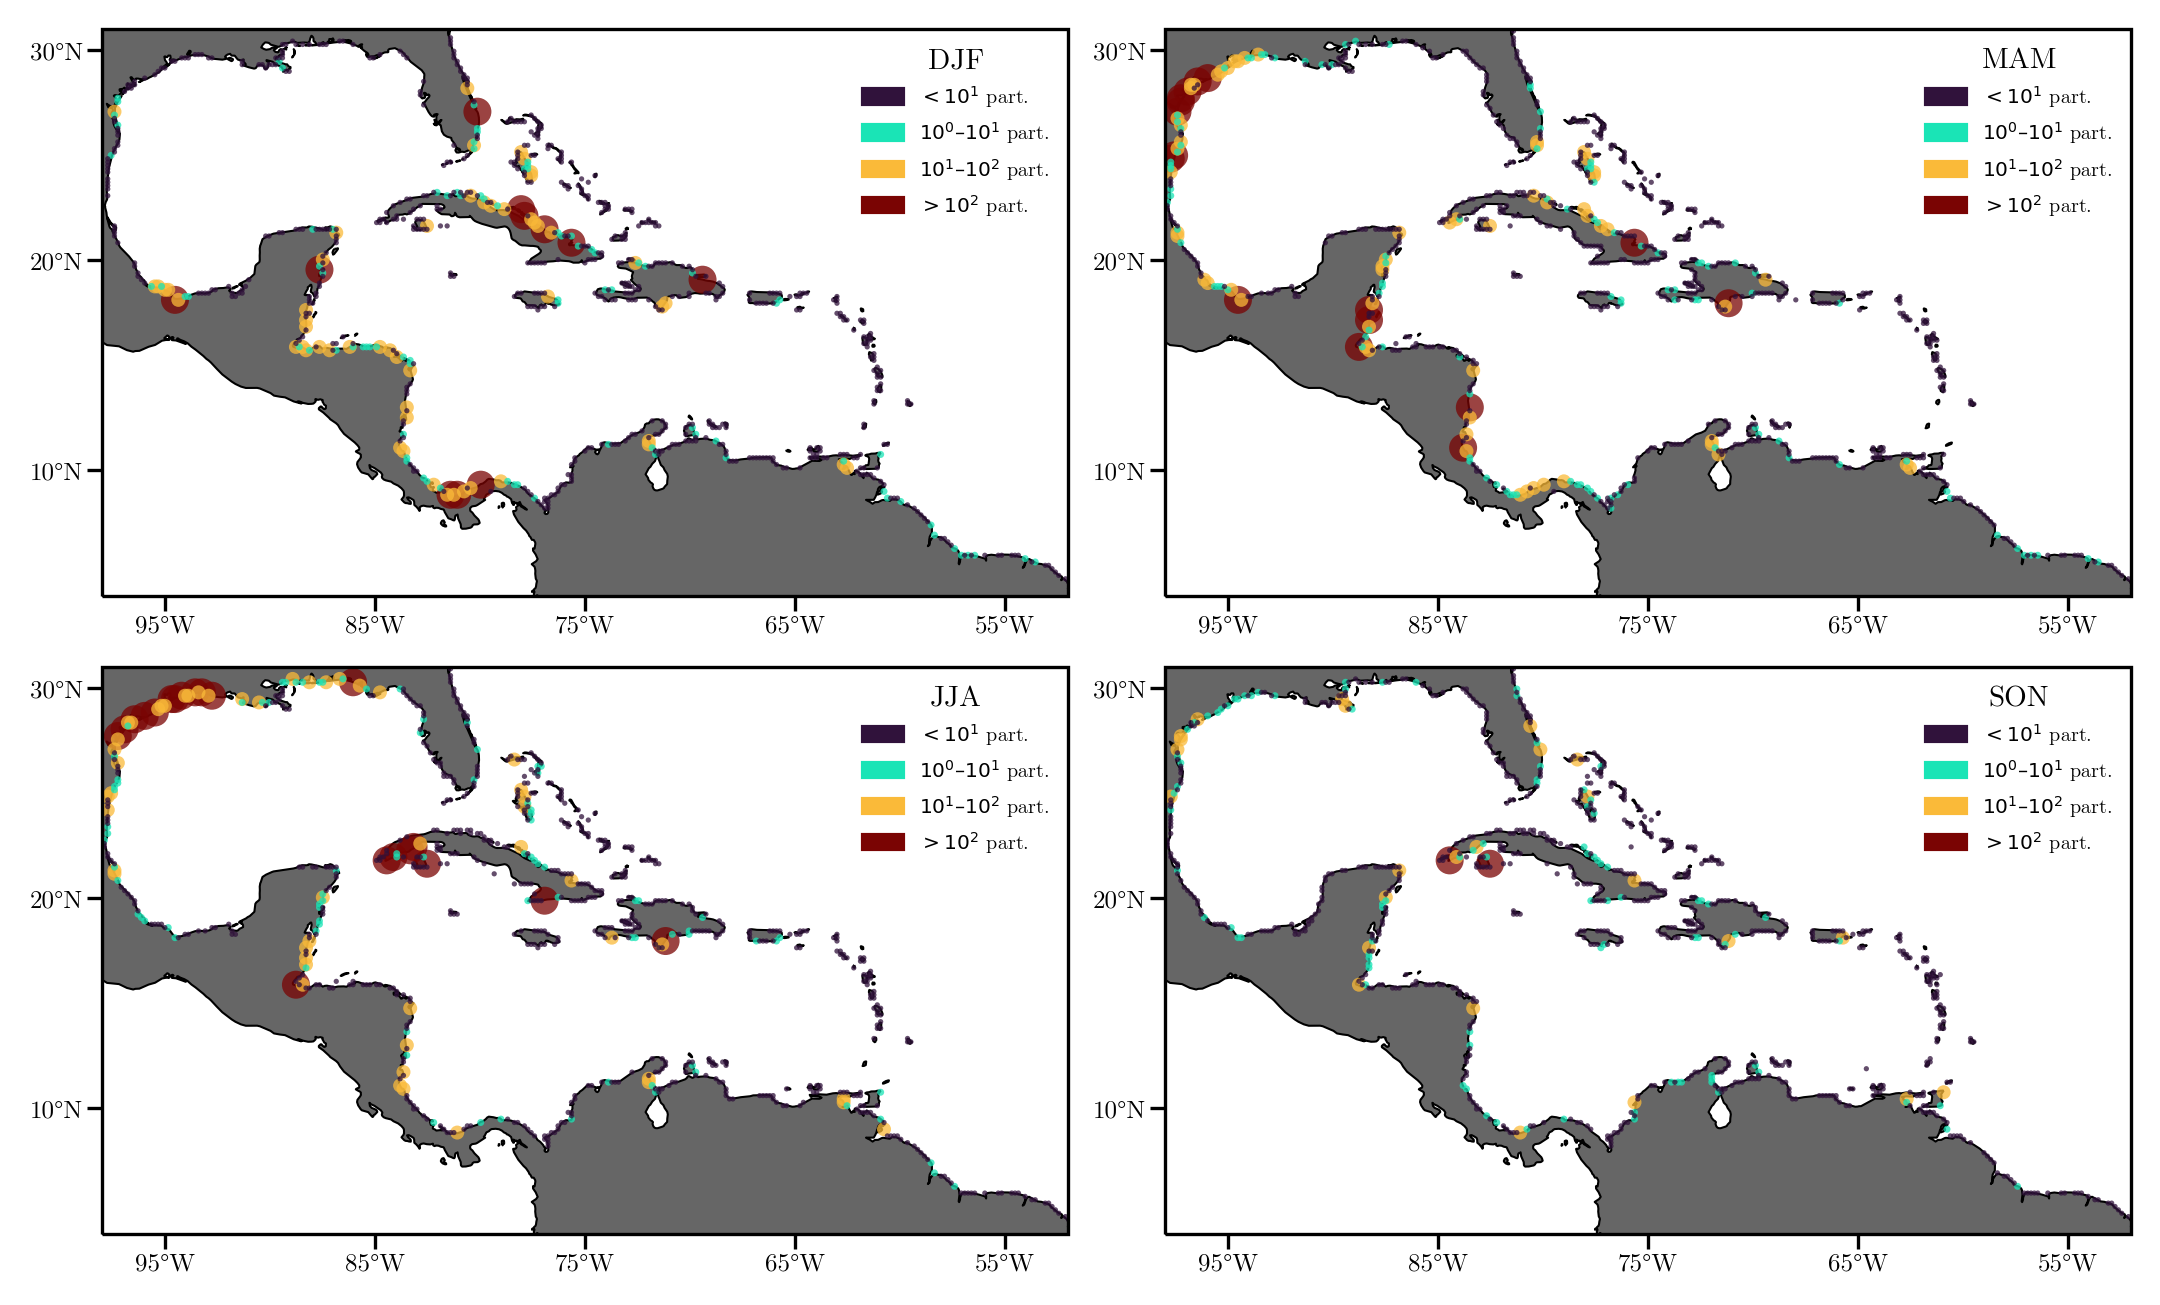

In [73]:
fig = plt.figure(dpi=300, figsize=(fs[0],0.6*fs[0]))
axes = create_axis(fig, 2, 2, proj=ccrs.PlateCarree())

for s, ax in enumerate(axes):
    geo_map(ax)

    #a = ax.scatter(plon[nnz[1]], plat[nnz[0]], 
    #           s=np.exp(beached_mass[nnz]/(0.20*np.nanmax(beached_mass))), 
    #          c=beached_mass[nnz], lw=2, marker='o',
    #          )

    #nnz = np.where(beached_mass)
    #colors, scaled_mass = radius(beached_mass[nnz])
    nnz = np.where(coastal_beached_mass_seasons[s])
    colors, scaled_mass = radius_season(coastal_beached_mass_seasons[s][nnz])

    patches = []
    for x1, y1, r in sorted(zip(plon[nnz[1]], plat[nnz[0]], scaled_mass), key = lambda x: x[2], reverse=True):
        circle = Circle((x1, y1), r)
        #circle = Wedge((x1, y1), r, 0, 360, width=0.1)
        patches.append(circle)

    cmap = plt.cm.turbo

    p = PatchCollection(patches, alpha=0.75, cmap=cmap_name)
    p.set_array(sorted(colors, reverse=True))
    p.set_clim([np.min(colors), np.max(colors)])
    ax.add_collection(p)
    
    #ax.set_title(f"Hotspots in {seasons[s]}")

    #fig.colorbar(p)

    handles = []
    handles.append(Polygon([(0,0),(5,0)], color=cmap(p.norm(np.min(colors))), label=f'$<10^{1}$ part.'))
    for i,c in enumerate(np.unique(colors)[1:-1]):
        handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap(p.norm(c)), label=f'$10^{i}–10^{i+1}$ part.'))
    handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap(p.norm(np.max(colors))), label=f'$>10^{i+1}$ part.'))
    ax.legend(handles=handles, frameon=False, fontsize='x-small')
    ax.get_legend().set_title(seasons[s])
    
fig.savefig(f'figures/hotspot_seasonality_uniform.png', format='png', dpi=600)